In [5]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

In [6]:
# 한글 시각화를 위한 seaborn 폰트 및 기본 설정
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='NanumBarunGothic',
              rc=custom_params)

### 데이터 로드 및 확인

In [7]:
# 데이터 호출하기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data2'
# data_dir = os.getenv('HOME')+'/aiffel/workplace/project/project_5'

aisles_data_path = join(data_dir, 'aisles.csv')
departments_data_path = join(data_dir, 'departments.csv') 
order_products__prior_data_path = join(data_dir, 'order_products__prior.csv') 
order_products__train_data_path = join(data_dir, 'order_products__train.csv') 
orders_data_path = join(data_dir, 'orders.csv') 
products_data_path = join(data_dir, 'products.csv') 
sample_data_path = join(data_dir, 'sample_submission.csv') 
# total_data_path = join(data_dir, 'total_df.csv') 

aisles = pd.read_csv(aisles_data_path)
dep = pd.read_csv(departments_data_path)
prior = pd.read_csv(order_products__prior_data_path)
train = pd.read_csv(order_products__train_data_path)
orders = pd.read_csv(orders_data_path)
products = pd.read_csv(products_data_path)
sample = pd.read_csv(sample_data_path)
# df = pd.read_csv(total_data_path)

print(f'aisles data dim : {aisles.shape}')
print(f'departments data dim : {dep.shape}')
print(f'order_products_prior data dim : {order_products_prior.shape}')
print(f'order_products_train data dim : {order_products_train.shape}')
print(f'orders data dim : {orders.shape}')
print(f'products data dim : {products.shape}')

In [8]:
# aisles = pd.read_csv("aisles.csv")
# dep = pd.read_csv("departments.csv")
# prior = pd.read_csv("order_products__prior.csv")
# train = pd.read_csv("order_products__train.csv")
# order = pd.read_csv("orders.csv")
# product = pd.read_csv("products.csv")
# submission = pd.read_csv("sample_submission.csv")

aisles.csv
- aisle_id: 통로 번호
- aisle: 통로 이름(제품이 위치한 구역)


departments.csv
- department_id: 부서 번호
- department: 부서 이름(물품 카테고리)


order_products__prior.csv / order_products__train.csv  
prior는 모든 고객의 이전 주문 내역이 포함되어있습니다.
- order_id: 주문 번호
- product_id: 구매한 제품의 번호
- add_to_cart_order: 카트에 담은 순서
- reordered: 재구매 여부


orders.csv
- order_id: 주문 번호
- user_id: 유저(구매자)의 번호(식별 번호)
- eval_set: 데이터가 속한 데이터셋(prior, train, test)
- order_number: 주문의 순서(1이 첫 구매)
- order_dow: 주문 요일
- order_hour_of_day: 주문이 이루어진 시각
- days_since_prior_order: 재방문까지 걸린 일자


products.csv
- product_id: 제품 번호
- product_name: 제품 이름
- aisle_id: 통로 번호(제품 위치)
- department_id: 부서 번호(물품 카테고리)

* 메모리 다이어트 함수 설정

In [9]:
def reduce_mem_usage(train_data):

#  iterate through all the columns of a dataframe and modify the data type to reduce memory usage."""
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
        end_mem = train_data.memory_usage().sum() / 1024**2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

In [10]:
reduce_mem_usage(prior)
reduce_mem_usage(train)
reduce_mem_usage(product)
reduce_mem_usage(order)
reduce_mem_usage(dep)
reduce_mem_usage(aisles)
print('complete!')

### 데이터 병합

In [11]:
product

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49686,Artisan Baguette,112,3
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


* 총 약 50000개의 제품 존재

In [12]:
print(len(prior) + len(train))
ot = pd.concat([prior, train])
ot = ot.sort_values(by='order_id').reset_index(drop=True)
ot

33819106


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,10246,3,0
2,1,49683,4,0
3,1,43633,5,1
4,1,13176,6,0
...,...,...,...,...
33819101,3421083,35211,5,0
33819102,3421083,39678,6,1
33819103,3421083,11352,7,0
33819104,3421083,4600,8,0


* 33819106개의 EDA재료

In [13]:
item_info = pd.merge(product, aisles, on ="aisle_id")
item_info

,product_id,product_name,aisle_id,department_id,aisle
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes
2,102,Danish Butter Cookies,61,19,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes
...,...,...,...,...,...
49683,47769,Peas and Potatoe Roti Paratha,76,6,indian foods
49684,48292,Punjabi Chhole Chickpeas with Potatoes & Onions,76,6,indian foods
49685,48480,Punjab Eggplant,76,6,indian foods
49686,48830,Pav Bhaji Mashed Vegetable Curry,76,6,indian foods


In [14]:
item_info = pd.merge(item_info, dep, on="department_id")
item_info

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks
...,...,...,...,...,...,...
49683,22827,Organic Black Mission Figs,18,10,bulk dried fruits vegetables,bulk
49684,28655,Crystallized Ginger Chunks,18,10,bulk dried fruits vegetables,bulk
49685,30365,Vegetable Chips,18,10,bulk dried fruits vegetables,bulk
49686,38007,Naturally Sweet Plantain Chips,18,10,bulk dried fruits vegetables,bulk


In [15]:
df = pd.merge(item_info, ot, on="product_id")
print(df.shape)
df

(33819106, 9)


,product_id,product_name,aisle_id,department_id,aisle,department,order_id,add_to_cart_order,reordered
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,1107,7,0
1,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,5319,3,1
2,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,6695,7,1
3,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,7540,4,1
4,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,9228,2,0
...,...,...,...,...,...,...,...,...,...
33819101,48778,"Fit Super A Juice, Cold Pressed, Carrot/Apple/...",18,10,bulk dried fruits vegetables,bulk,3054471,19,1
33819102,48778,"Fit Super A Juice, Cold Pressed, Carrot/Apple/...",18,10,bulk dried fruits vegetables,bulk,3136178,12,0
33819103,48778,"Fit Super A Juice, Cold Pressed, Carrot/Apple/...",18,10,bulk dried fruits vegetables,bulk,3174062,10,0
33819104,48778,"Fit Super A Juice, Cold Pressed, Carrot/Apple/...",18,10,bulk dried fruits vegetables,bulk,3220368,16,0


In [16]:
df = pd.merge(df, order, on='order_id')
print(df.shape)
df

(33819106, 15)


,product_id,product_name,aisle_id,department_id,aisle,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,1107,7,0,38259,prior,2,1,11,7.0
1,46149,Zero Calorie Cola,77,7,soft drinks,beverages,1107,6,0,38259,prior,2,1,11,7.0
2,9434,Bag of Large Lemons,34,1,frozen meat seafood,frozen,1107,2,0,38259,prior,2,1,11,7.0
3,769,Sliced American Cheese,21,16,packaged cheese,dairy eggs,1107,10,0,38259,prior,2,1,11,7.0
4,12078,Shredded Mexican Blend Cheese,21,16,packaged cheese,dairy eggs,1107,9,0,38259,prior,2,1,11,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,30365,Vegetable Chips,18,10,bulk dried fruits vegetables,bulk,2323735,1,1,90235,prior,30,3,10,1.0
33819102,30365,Vegetable Chips,18,10,bulk dried fruits vegetables,bulk,2733396,1,0,30511,prior,24,4,11,0.0
33819103,30365,Vegetable Chips,18,10,bulk dried fruits vegetables,bulk,3152383,1,0,10113,train,12,3,19,13.0
33819104,48778,"Fit Super A Juice, Cold Pressed, Carrot/Apple/...",18,10,bulk dried fruits vegetables,bulk,31522,1,1,31188,prior,3,3,11,4.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   product_id              int64  
 1   product_name            object 
 2   aisle_id                int64  
 3   department_id           int64  
 4   aisle                   object 
 5   department              object 
 6   order_id                int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


### 가장 많이 팔린 품목 확인

In [18]:
top_product = df['product_name'].value_counts().head(10)
top_product

product_name
Banana                    491291
Bag of Organic Bananas    394930
Organic Strawberries      275577
Organic Baby Spinach      251705
Organic Hass Avocado      220877
Organic Avocado           184224
Large Lemon               160792
Strawberries              149445
Limes                     146660
Organic Whole Milk        142813
Name: count, dtype: int64

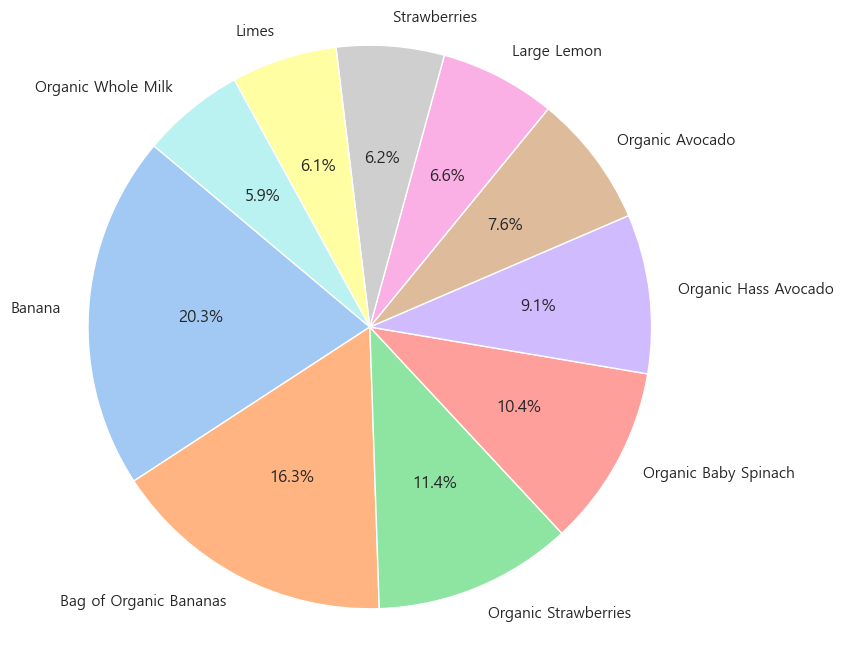

In [19]:
labels = top_product.index
sizes = top_product.values

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.axis('equal')

plt.show()

* 직관적으로 보았을땐 바나나 단품, 바나나 한묶음이 제일 많이 팔린 물품
* 주목해야 할 점은 상위 10개 품목의 대부분을 차지하고 있는 Organic(유기농)이라는 키워드

### 1. 바나나 구매왕 찾기 이벤트!
a. 바나나 부자 : 제일 많은 바나나를 사신 분

In [20]:
# 전체 판매 품목중 Banana 단어가 들어간 품목 골라내기
banana_df = product[product['product_name'].str.contains('Banana')].reset_index(drop=True)
banana_df

,product_id,product_name,aisle_id,department_id
0,63,Banana & Sweet Potato Organic Teething Wafers,92,18
1,313,Peppermint/Banana Split Variety Pack Frozen Da...,37,1
2,426,2nd Foods Bananas,92,18
3,602,Banana Chocolate Chip,52,1
4,849,Blueberry & Banana Tiny Fruits Freeze Dried Sn...,92,18
...,...,...,...,...
371,49201,"Banana, Peach and Mango Fruit Pouch",92,18
372,49310,Oatmeal & Banana Baby Cereal,92,18
373,49337,Stage 2 Banana Sweet Pea Papaya Baby Food,92,18
374,49498,Beeswax & Banana Hand Creme,127,11


In [21]:
# Banana가 들어간 품목중 순수 Banana만 골라냄
selected_products = ["Green Bananas", "Banana", "Bag of Organic Bananas", "Red Banana", "Baby Banana", "Baby Bananas", "Manzano Banana", "Organic Banana", "Bananas"]
banana_df2 = df[df['product_name'].isin(selected_products)]
banana_df2

,product_id,product_name,aisle_id,department_id,aisle,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
11,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,1107,3,1,38259,prior,2,1,11,7.0
278,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,43669,1,1,199115,prior,20,1,18,26.0
473,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,82631,6,1,60380,prior,26,4,10,10.0
583,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,107716,2,1,80421,prior,8,0,14,18.0
606,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,108894,11,1,137274,prior,16,1,15,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33751178,39276,Bananas,24,4,fresh fruits,produce,3151988,1,1,152799,prior,55,0,12,2.0
33751179,39276,Bananas,24,4,fresh fruits,produce,3217685,1,1,193215,prior,17,3,18,10.0
33751180,39276,Bananas,24,4,fresh fruits,produce,3256309,1,1,193215,prior,7,0,15,3.0
33751181,39276,Bananas,24,4,fresh fruits,produce,3258045,1,1,11397,prior,33,1,16,10.0


In [22]:
# 순수 Banana 구매 고객중 상위 30명 선정
banana_df3 = banana_df2['user_id'].value_counts().sort_values(ascending=False).head(30)
banana_df3

user_id
99707     98
124991    97
69919     97
178107    95
54804     93
189425    92
194931    92
74315     92
32971     91
120232    91
90110     89
41356     89
71049     89
64320     88
53673     86
105213    85
171132    85
9682      84
54594     84
174046    84
184451    84
132298    83
31087     83
47855     83
54485     83
67440     82
195804    82
27353     82
175540    82
126715    81
Name: count, dtype: int64

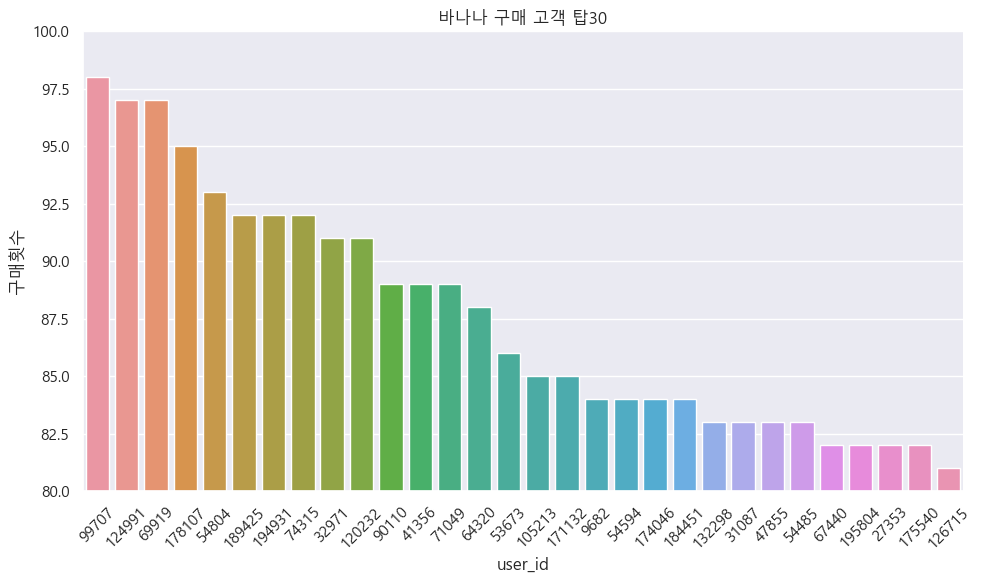

In [23]:
plt.figure(figsize=(10, 6))

sns.barplot(x=banana_df3.index.astype(str), y=banana_df3.values)
plt.title('바나나 구매 고객 탑30')
plt.xlabel('user_id')
plt.ylabel('구매횟수')
plt.ylim(80, 100)
plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()

b. 바나나 바라기 : 바나나를 제일 많이 사고 또 사신 분

In [24]:
# banana데이터에서 재주문횟수가 제일 높은 고객만 도출
banana_reorder = banana_df2.groupby('user_id')['reordered'].sum()
banana_reorder = banana_reorder_sorted = banana_reorder.sort_values(ascending=False)
banana_reorder

user_id
99707     97
69919     96
124991    95
178107    94
189425    91
          ..
171061     0
46903      0
90625      0
46915      0
134256     0
Name: reordered, Length: 124253, dtype: int64

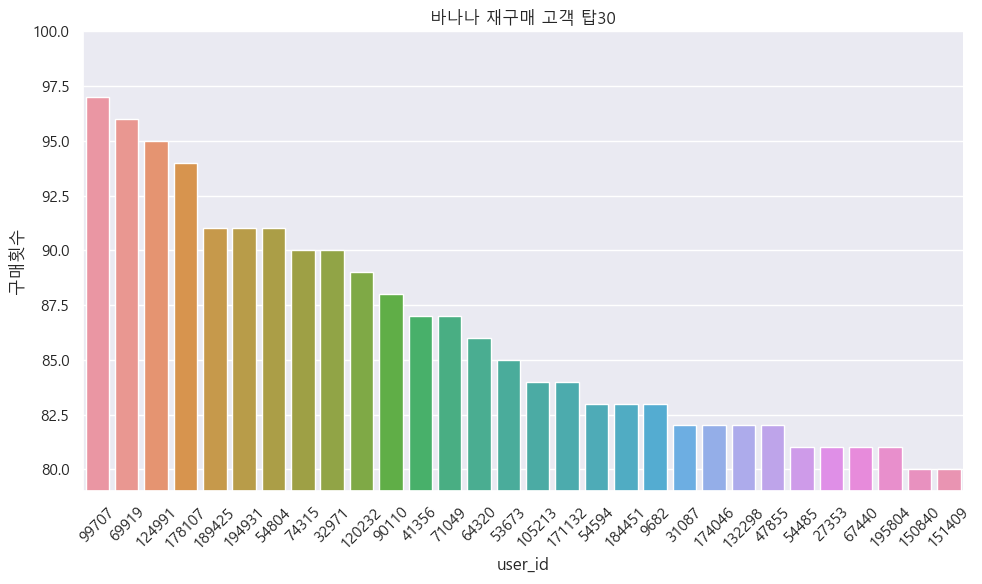

In [25]:
plt.figure(figsize=(10, 6))

sns.barplot(x=banana_reorder.index[:30].astype(str), y=banana_reorder.values[:30])
plt.title('바나나 재구매 고객 탑30')
plt.xlabel('user_id')
plt.ylabel('구매횟수')
plt.ylim(79, 100)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

* 바나나 구매 횟수와 재구매 횟수는 매우 당연하게도 동일한 결과를 뽑아냄

In [26]:
# train확인
train_df = df[df['eval_set'] == 'train']
train_df

,product_id,product_name,aisle_id,department_id,aisle,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
24,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,6695,7,1,1540,train,29,1,1,8.0
25,40199,Chocolate Chip Cookies,61,19,cookies cakes,snacks,6695,17,1,1540,train,29,1,1,8.0
26,45051,Pub Mix,107,19,chips pretzels,snacks,6695,6,1,1540,train,29,1,1,8.0
27,10310,Wheat Thins Original,78,19,crackers,snacks,6695,20,1,1540,train,29,1,1,8.0
28,37600,Organic Kettle Corn,23,19,popcorn jerky,snacks,6695,1,1,1540,train,29,1,1,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33818973,5161,Dried Mango,18,10,bulk dried fruits vegetables,bulk,1656340,1,1,29207,train,17,0,10,10.0
33818995,5161,Dried Mango,18,10,bulk dried fruits vegetables,bulk,1875412,1,1,28831,train,94,5,13,0.0
33818998,5161,Dried Mango,18,10,bulk dried fruits vegetables,bulk,1892376,1,1,98935,train,31,1,10,26.0
33819057,5161,Dried Mango,18,10,bulk dried fruits vegetables,bulk,3111299,1,1,198410,train,14,6,9,2.0


In [27]:
banana_train = train_df[train_df['product_name'].isin(selected_products)]
banana_train

,product_id,product_name,aisle_id,department_id,aisle,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1189,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,253400,8,1,21054,train,4,3,14,30.0
2596,24852,Banana,24,4,fresh fruits,produce,468768,1,1,14910,train,61,5,11,7.0
4237,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,767323,3,1,2221,train,24,5,19,16.0
6011,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,1091681,2,1,184744,train,72,4,14,3.0
11287,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,2050666,3,0,193585,train,4,5,9,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33750192,37067,Organic Banana,24,4,fresh fruits,produce,2833920,1,1,78409,train,27,5,13,2.0
33751102,39276,Bananas,24,4,fresh fruits,produce,378812,2,0,194872,train,8,0,15,30.0
33751112,39276,Bananas,24,4,fresh fruits,produce,509455,1,1,108134,train,4,4,16,30.0
33751134,39276,Bananas,24,4,fresh fruits,produce,1618153,1,0,26935,train,52,1,6,4.0


In [28]:
banana_train['user_id'].nunique()
#train 확인 끝

36867

* train데이터는 고객별 제일 최근 구매데이터지만 구매 수량이 따로 없기때문에 바나나를 구매한 train의 갯수와 고객의 갯수가 같은수준임.

### 1 - 2. 유기농구매
* 위쪽 pieplot 시각화를 확인해보면 Organic(유기농)단어가 상당히 큰 비중을 차지함

In [29]:
# 전체 판매 품목중 Organic단어가 포함된 품목선정
organic_df = product[product['product_name'].str.contains('Organic')].reset_index(drop=True)
organic_df

,product_id,product_name,aisle_id,department_id
0,23,Organic Turkey Burgers,49,12
1,33,Organic Spaghetti Style Pasta,131,9
2,41,Organic Sourdough Einkorn Crackers Rosemary,78,19
3,43,Organic Clementines,123,4
4,47,Onion Flavor Organic Roasted Seaweed Snack,66,6
...,...,...,...,...
5030,49606,Organic Natural Red,28,5
5031,49608,Certified Organic Spanish Style Rice With Quin...,4,9
5032,49638,Organic Superfirm Vacuum Packed Tofu,14,20
5033,49653,Organic Aromatherapeutic Moroccan Argan Oil Set,25,11


0.10133231363709548


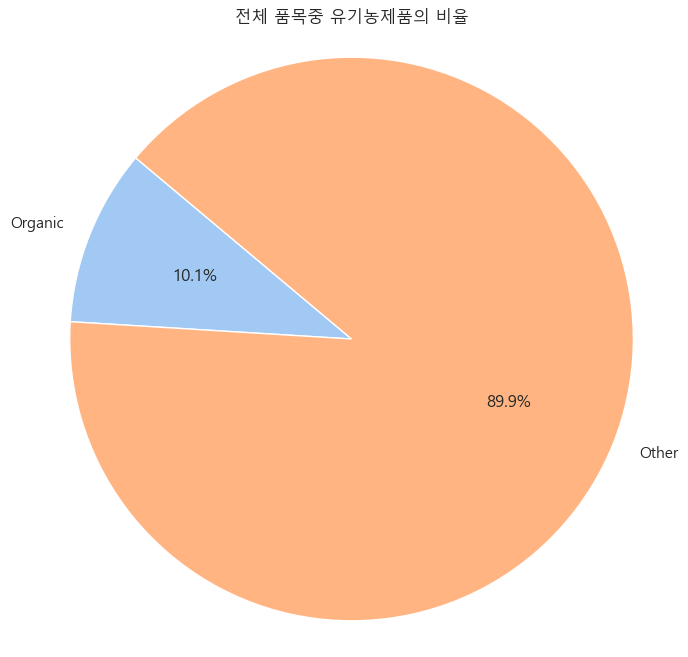

In [30]:
# 전체 품목에서의 유기농 품목의 비율
print(len(organic_df) / len(product))

data = [len(organic_df), len(product) - len(organic_df)]
labels = ['Organic', 'Other']

plt.figure(figsize=(8, 8))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)

plt.title('전체 품목중 유기농제품의 비율')
plt.axis('equal')

plt.show()

* 약 5만개의 판매품목중 유기농 제품은 10퍼센트를 차지함

In [31]:
# 전체 판매내역중 유기농 제품 판매내역 확인
organic_df2 = df[df['product_name'].isin(organic_df['product_name'].values)]
organic_df2

,product_id,product_name,aisle_id,department_id,aisle,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,28413,Bunny-Luv Organic Carrots,83,4,fresh vegetables,produce,1107,13,0,38259,prior,2,1,11,7.0
11,13176,Bag of Organic Bananas,24,4,fresh fruits,produce,1107,3,1,38259,prior,2,1,11,7.0
28,37600,Organic Kettle Corn,23,19,popcorn jerky,snacks,6695,1,1,1540,train,29,1,1,8.0
33,12542,Organic Creamy Almond Butter,88,13,spreads,pantry,6695,8,1,1540,train,29,1,1,8.0
34,26317,Organic Lemonade,98,7,juice nectars,beverages,6695,11,1,1540,train,29,1,1,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819087,22827,Organic Black Mission Figs,18,10,bulk dried fruits vegetables,bulk,1257076,1,0,75662,prior,5,5,16,30.0
33819088,22827,Organic Black Mission Figs,18,10,bulk dried fruits vegetables,bulk,2263873,1,1,6871,prior,8,6,16,2.0
33819089,22827,Organic Black Mission Figs,18,10,bulk dried fruits vegetables,bulk,2398850,1,0,202404,prior,3,4,20,1.0
33819090,22827,Organic Black Mission Figs,18,10,bulk dried fruits vegetables,bulk,3072891,1,0,159218,prior,16,1,9,27.0


In [32]:
# 유기농제품이 들어있는 카테고리 확인
organic_df2['department'].unique()

array(['produce', 'snacks', 'pantry', 'beverages', 'deli', 'dairy eggs',
       'frozen', 'canned goods', 'bakery', 'dry goods pasta',
       'meat seafood', 'missing', 'breakfast', 'babies', 'personal care',
       'international', 'bulk', 'pets', 'other', 'household', 'alcohol'],
      dtype=object)

* Organic(유기농)이라는 키워드는 상당히 잘먹히는 키워드라 전혀 어울리지 않는 alcohol(주류)제품에도 유기농 키워드가 포함되어있음

In [33]:
# 유기농 주류 제품명 확인
print(set(organic_df2[organic_df2['department'] == 'alcohol']['product_name']))

{'Natural White Organic Wine', 'Organic Reposado Tequila', 'Lager Beer, Organic, Pure Brewed', 'Organic Nama Sake', 'Organic & Raw Grape Kombucha', 'Organic Zero Sulfites Red Wine', 'Organic Natural Red', 'Organic Cider', 'Organic Chardonnay', 'Organic Chocolate Stout', 'Organic Malbec', 'Organic Pinot Noir', 'Organic Sauvignon Blanc', 'Organic Mendocino Cabernet Sauvignon', 'Organic Pale Ale'}


0.31508780864875613


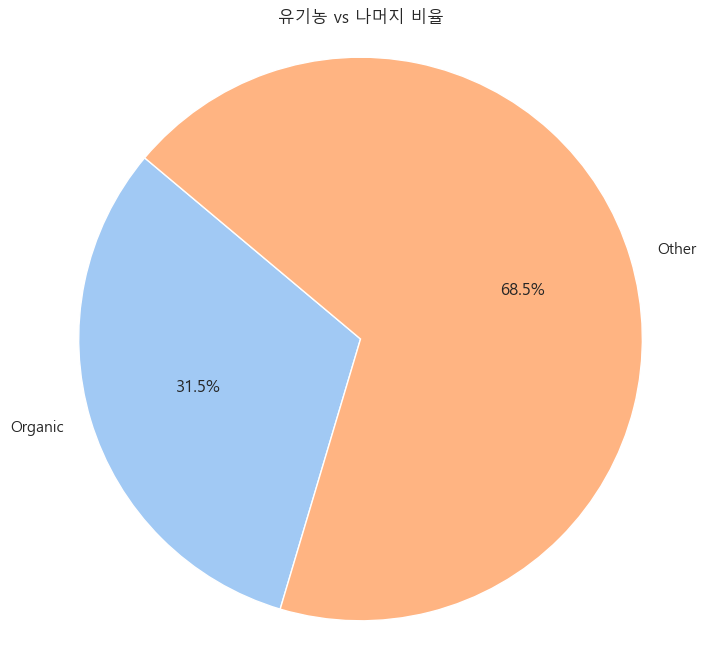

In [34]:
# 전체 판매 내역중 유기농 판매 비율
print(len(organic_df2) / len(df))

data = [len(organic_df2), len(df) - len(organic_df2)]
labels = ['Organic', 'Other']

plt.figure(figsize=(8, 8))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)

plt.title('유기농 vs 나머지 비율')
plt.axis('equal')

plt.show()

* 유기농제품이 전체 판매 품목에서 30%이상을 담당함. 매우 큰 비중

In [35]:
# 유기농제품을 가장 많이 구매한 user_id 추출
organic_df3 = organic_df2['user_id'].value_counts().sort_values(ascending=False).head(30)
organic_df3

user_id
182401    1428
175540    1359
38683     1339
84474     1327
88698     1317
160106    1305
115495    1296
175627    1293
73080     1291
143402    1253
195573    1245
190736    1200
108187    1193
66806     1177
105213    1166
132022    1157
1563      1152
106161    1151
145686    1141
1424      1136
121327    1122
103634    1108
142131    1107
89048     1102
74336     1099
3830      1095
205804    1092
36445     1090
37592     1088
176970    1076
Name: count, dtype: int64

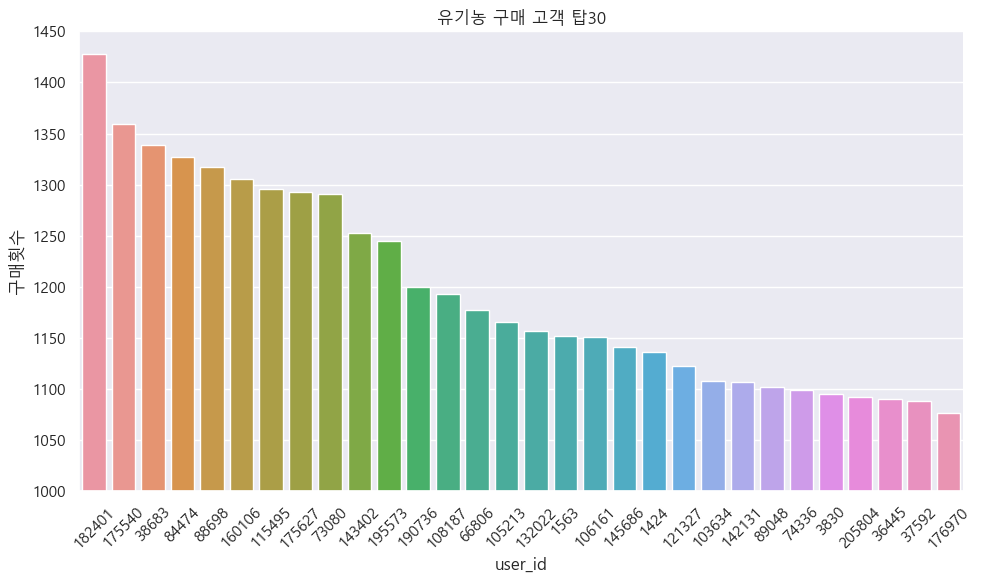

In [36]:
plt.figure(figsize=(10, 6))

sns.barplot(x=organic_df3.index.astype(str), y=organic_df3.values)
plt.title('유기농 구매 고객 탑30')
plt.xlabel('user_id')
plt.ylabel('구매횟수')
plt.ylim(1000, 1450)
plt.xticks(rotation=45) 
plt.tight_layout()

plt.show()

* 유기농 제품을 제일 많이 구매한 고객을 시각화로 확인
* 해당 자료를 토대로 이색리워드 개념처럼 "유기농 왕" 같은 수상을 하며 고객 서비스 제공 가능

### 2. 재구매집착증
* 재구매 비율이 높은 상품중 판매비율이 유의미한 제품 판별한 후 제품의 특징 파악하기

In [37]:
product_reorder_counts = df.groupby('product_name')['reordered'].agg(['sum', 'count'])
product_reorder_counts.columns = ['reordered_count', 'total_count']

product_reorder_counts['reorder_ratio'] = product_reorder_counts['reordered_count'] / product_reorder_counts['total_count']

top_reorder_ratio = product_reorder_counts.sort_values(by='reorder_ratio', ascending=False)
filtered_top_reorder_ratio = top_reorder_ratio[top_reorder_ratio['total_count'] >= 10000] # 총 판매 갯수 10000개 이상만 보기
filtered_top_reorder_ratio.head(20)

,reordered_count,total_count,reorder_ratio
product_name,,,
"Milk, Organic, Vitamin D",17753,20770,0.854742
Organic Reduced Fat Milk,31394,36869,0.851501
Banana,415166,491291,0.845051
Organic Lowfat 1% Milk,12914,15352,0.841193
Organic Whole Milk,8494,10102,0.840824
"Organic Milk Reduced Fat, 2% Milkfat",10984,13119,0.837259
Bag of Organic Bananas,329275,394930,0.833755
Organic Fat Free Milk,22824,27402,0.832932
Organic Whole Milk,118684,142813,0.831045


* 재구매 비율이 높은제품은  '우유' '요거트'
* 우유는 곧 유제품(dairy eggs)이라는 카테고리에 들어있음 해서 카테고리별 재구매비율을 구해봄
* 해당 표에서의 재미있는 사실은 유제품 조차도 Organic이라는 키워드가 들어간 제품을 선호함

In [38]:
# 카테고리별 재주문 비율 확인하기
dpt_reorder_counts = df.groupby('department')['reordered'].agg(['sum', 'count'])
dpt_reorder_counts.columns = ['reordered_count', 'total_count']

dpt_reorder_counts['reorder_ratio'] = dpt_reorder_counts['reordered_count'] / dpt_reorder_counts['total_count']

top_reorder_ratio = dpt_reorder_counts.sort_values(by='reorder_ratio', ascending=False)
filtered_top_reorder_ratio = top_reorder_ratio[top_reorder_ratio['total_count'] >= 1000]
filtered_top_reorder_ratio

,reordered_count,total_count,reorder_ratio
department,,,
dairy eggs,3773723,5631067,0.670161
beverages,1832952,2804175,0.653651
produce,6432596,9888378,0.650521
bakery,769880,1225181,0.628381
deli,666231,1095540,0.608130
pets,61594,102221,0.602557
babies,253453,438743,0.577680
bulk,20736,35932,0.577090
snacks,1727075,3006412,0.574464


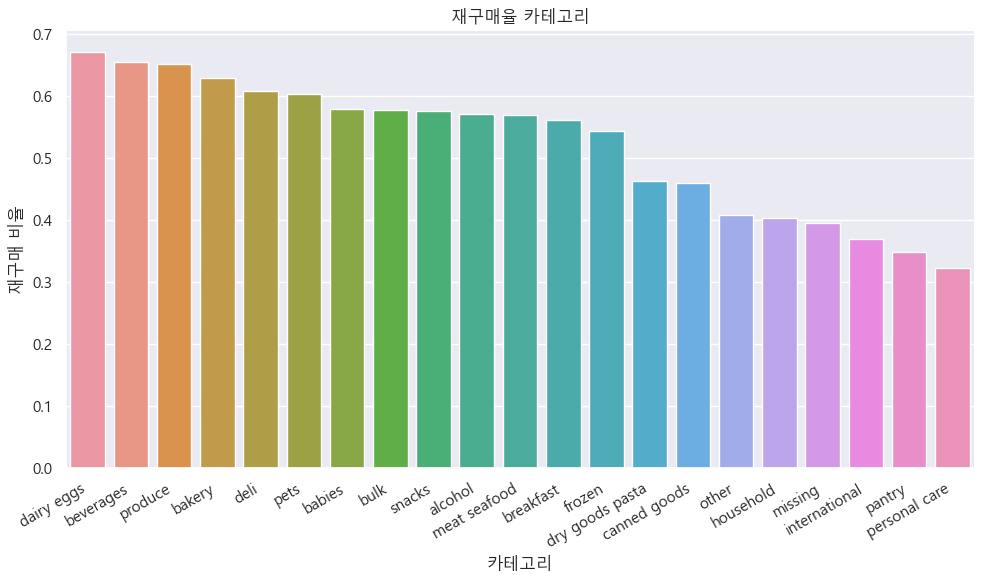

In [125]:
plt.figure(figsize=(10, 6))

ax0 = sns.barplot(data=filtered_top_reorder_ratio, x=filtered_top_reorder_ratio.index, y='reorder_ratio')
plt.title('재구매율 카테고리')
plt.xlabel('카테고리')
plt.ylabel('재구매 비율')
ax0.set_xticklabels(ax0.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()

plt.show()

* 유제품이 예상대로 가장 재주문율이 높음
* 전체 판매량은 낮지만 재주문율은 높은 카테고리도 분명 존재 (ex : pets)

In [40]:
# 보너스 목표 : 재주문율이 가장높은 제품 하나 선정해서 가장많이 구매한 고객 추출
h_h = df[df['product_name'] == 'Organic Reduced Fat Milk']
h_h

,product_id,product_name,aisle_id,department_id,aisle,department,order_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
49325,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,184509,25,1,63799,prior,26,0,16,0.0
49764,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,2547170,1,1,63799,prior,19,0,18,5.0
49861,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,3202999,5,1,63799,prior,25,0,16,7.0
50507,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,656814,31,1,53190,prior,38,0,15,6.0
51210,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,2028589,2,1,128635,prior,4,1,14,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32840503,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,3415242,2,1,7648,prior,9,1,5,30.0
32840506,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,3418049,3,1,187254,prior,11,1,18,29.0
32840515,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,3419331,1,1,179134,prior,10,3,8,9.0
32840519,38689,Organic Reduced Fat Milk,84,16,milk,dairy eggs,3420665,1,1,42893,prior,8,0,11,16.0


In [132]:
e_e = h_h['user_id'].value_counts()
e_e

user_id
99753     96
180621    90
41356     82
150313    82
65320     76
          ..
123788     1
122866     1
161873     1
74510      1
152556     1
Name: count, Length: 5475, dtype: int64

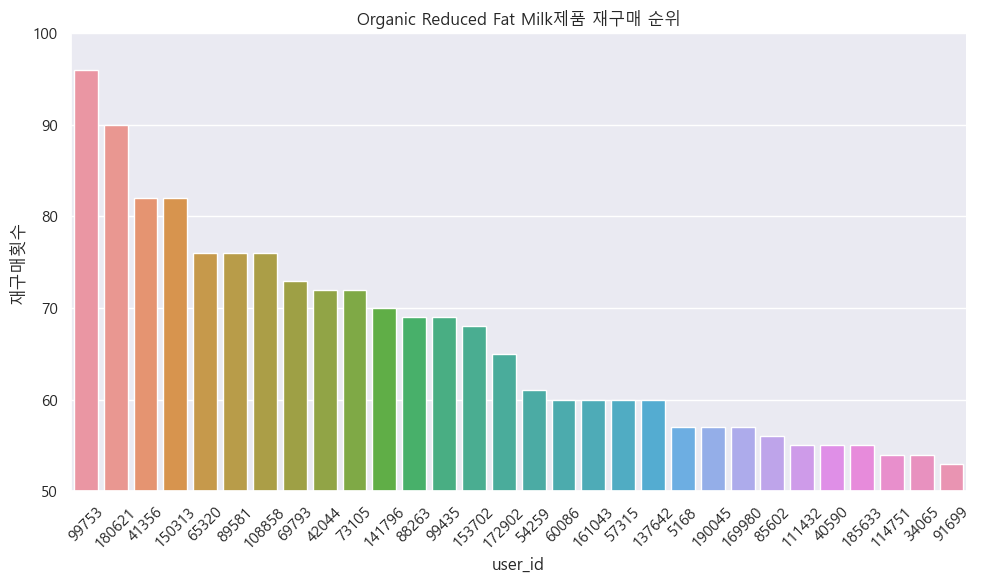

In [135]:
plt.figure(figsize=(10, 6))

sns.barplot(x=e_e.index[:30].astype(str), y=e_e.values[:30])
plt.title('Organic Reduced Fat Milk제품 재구매 순위')
plt.xlabel('user_id')
plt.ylabel('재구매횟수')
plt.ylim(50, 100)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### 3. 마트의 가장 핫한 코너는???
- 불티나게 팔리는 진열대는 어디인가?!?!?
--------------------
### 4. 마트의 가장 조용한 곳...
- 가장 판매실적이 부족한 진열대는 어디??!

In [42]:
position_df = df[['order_id', 'product_id', 'product_name', 'aisle', 'department']]

In [43]:
# 각 aisle의 주문 횟수 계산
aisle_counts = position_df['aisle'].value_counts().reset_index()
aisle_counts.columns = ['aisle', 'order_count']
aisle_counts['aisle'] = aisle_counts['aisle'].astype(str)
aisle_counts

,aisle,order_count
0,fresh fruits,3792661
1,fresh vegetables,3568630
2,packaged vegetables fruits,1843806
3,yogurt,1507583
4,packaged cheese,1021462
...,...,...
129,eye ear care,9522
130,baby bath body care,8909
131,baby accessories,8466
132,beauty,6455


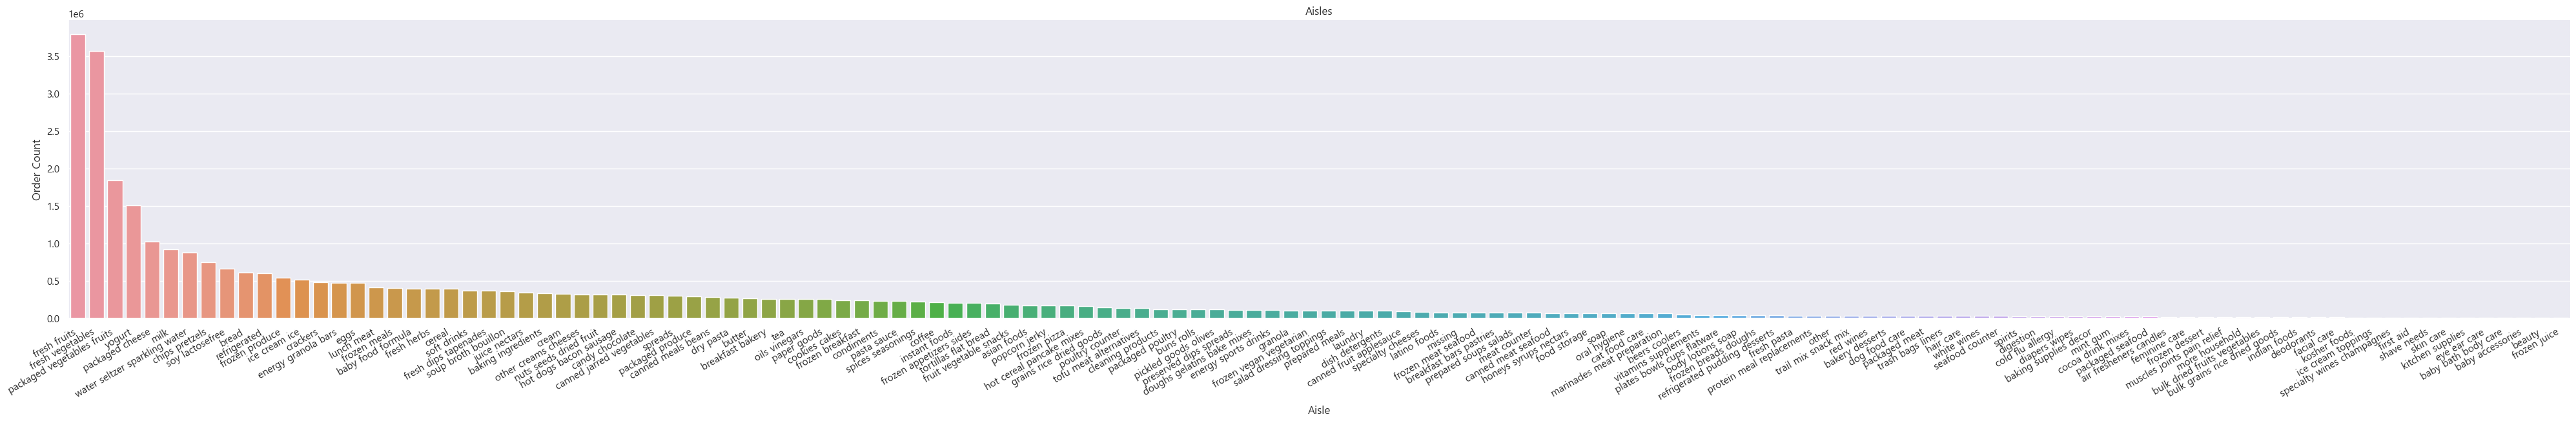

In [44]:
# 전체 제품 위치한 구역의 통로이름 별 주문 수량 시각화
plt.figure(figsize=(50, 6))
ax = sns.barplot(x=aisle_counts["aisle"], y=aisle_counts["order_count"], data=aisle_counts)
plt.title("Aisles")
plt.xlabel("Aisle")
plt.ylabel("Order Count")
# plt.xticks(rotation=30)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

* 주문량이 많은 통로 구역이 있고, 주문량이 그저그런 통로 구역이 있고, 주문량이 저조한 통로 구역이 있음
* 구역별 주문량의 차이가 매우 큼

In [45]:
# 제품 위치한 구역의 통로이름 별 주문 수량 top10 / bottom10 시각화
# 데이터프레임에서 상위 10개와 하위 10개 aisle 추출
top_10_aisles = aisle_counts.head(10)
bottom_10_aisles = aisle_counts.tail(10)
top_10_aisles

,aisle,order_count
0,fresh fruits,3792661
1,fresh vegetables,3568630
2,packaged vegetables fruits,1843806
3,yogurt,1507583
4,packaged cheese,1021462
5,milk,923659
6,water seltzer sparkling water,878150
7,chips pretzels,753739
8,soy lactosefree,664493
9,bread,608469


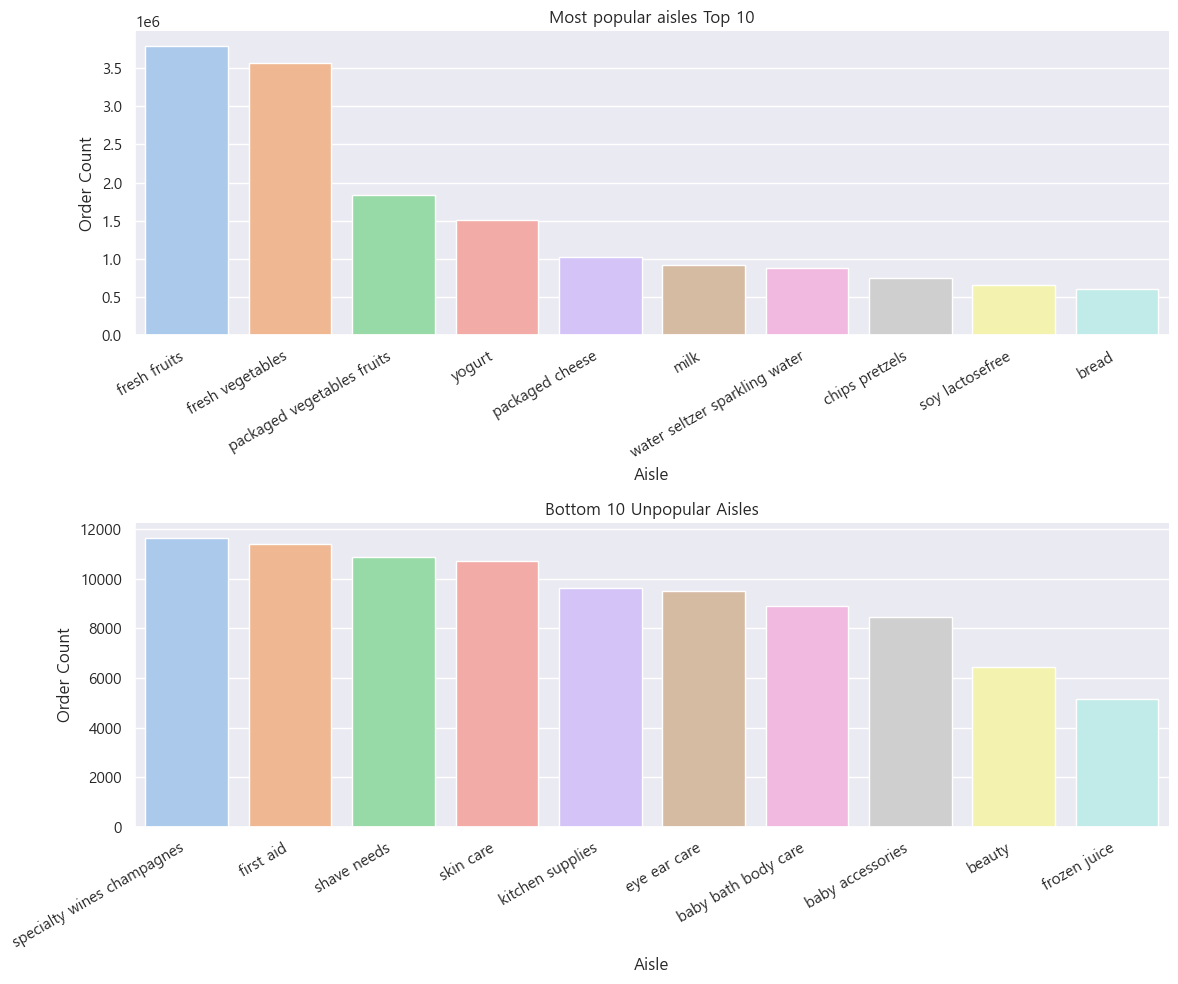

In [46]:
plt.figure(figsize=(12, 10))

# 가장 인기 있는 aisle 시각화
plt.subplot(2, 1, 1)
ax1 = sns.barplot(x=top_10_aisles["aisle"], y=top_10_aisles["order_count"], data=top_10_aisles)
plt.title("Most popular aisles Top 10")
plt.xlabel("Aisle")
plt.ylabel("Order Count")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

# 가장 인기가 없는 aisle 시각화
plt.subplot(2, 1, 2)
ax2 = sns.barplot(x=bottom_10_aisles["aisle"], y=bottom_10_aisles["order_count"], data=bottom_10_aisles)
plt.title("Bottom 10 Unpopular Aisles")
plt.xlabel("Aisle")
plt.ylabel("Order Count")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.show()

* 상위 품목들은 모두 식품들
* 하위 품목들은 식품과 관련이 없는 제품들이 대다수
* 제일 낮은 냉동 음료의 판매율이 저조한 이유를 현재 컨셉에 맞춘 유기농에 집중해봄

In [47]:
# 냉동음료 제품중 Organic키워드가 들어간 제품 찾기
frozen_j = list(set(df[df['aisle'] == 'frozen juice']['product_name']))
print(len(frozen_j))
print(frozen_j)

47
['Organic Orange Juice Concentrate', 'Orange Peach Mango Juice', 'Apple Cherry Concentrate Frozen', 'Orange Original Frozen Concentrate 100% Juice', 'Smoothies, Strawberries Wild', '100% Grape Juice Concentrate', 'Frozen Concentrated Pulp Free Orange Juice', 'Premium Lemon Juice', 'Caribbean Passion All Natural Smoothies', 'Premium Pink Lemonade Concentrate', 'Tropical Fruit Smoothie Tasty American Favorites', 'Blended Juice Beverage, Mango Orange', 'Orange Juice with Calcium', 'Frozen Concentrate Non-Alcoholic Strawberry Daiquiri', 'Blue Fusion Fruit & Veggie Smoothie', 'Strawberry Banana Smoothie Tasty American Favorites', 'Frozen Orange Juice', 'Green Fusion Fruit & Veggie Smoothie Blend', 'All Natural Smoothies Razzmatazz', 'Real Pure Acai', 'Organic Cranberry Concentrate', 'Non-Alcoholic Margarita Mix', 'Frozen Concentrated Orange Juice', 'Apple Kiwi Strawberry Concentrate Frozen', '100% White Grape Juice Concentrate', 'No Pulp Frozen Concentrated Orange Juice', 'Frozen Concent

In [48]:
o_f = []
for i in frozen_j:
    if "Organic" in i:
        o_f.append(i)
print(len(o_f), (o_f))

4 ['Organic Orange Juice Concentrate', 'Organic Cranberry Concentrate', 'Pitaya Dragonfruit Raw, Organic Smoothie Packs', 'Organic Frozen Concentrate Lemonade']


* 냉동음료 총 47개중 유기농 제품 4개

In [49]:
frozen_j_df = df[df['aisle'] == 'frozen juice']
f_j_d_c = frozen_j_df['product_name'].value_counts()
f_j_d_c

product_name
Orange Juice with Calcium                               697
Smoothies, Strawberries Wild                            499
Real Pure Acai                                          320
Pitaya Dragonfruit Raw, Organic Smoothie Packs          318
Frozen Lemonade Concentrate                             302
Organic Orange Juice Concentrate                        276
All Natural Smoothies Razzmatazz                        248
All Natural Smoothies Orange Dream Machine              233
Frozen Limeade Concentrate                              212
Frozen Concentrated Original Orange Juice               205
Green Fusion Fruit & Veggie Smoothie Blend              193
Organic Cranberry Concentrate                           192
Frozen Orange Juice                                     166
Organic Frozen Concentrate Lemonade                     148
All Natural Smoothies Mango-a-go-go                     111
Frozen Concentrated Pulp Free Orange Juice              106
Frozen Concentrated Orange 

In [50]:
# 냉동 음료중 Organic키워드가 들어간 제품의 판매 갯수만 출력
organic_fj = f_j_d_c[f_j_d_c.index.str.contains('Organic')].reset_index(drop=True)
organic_fj

0    318
1    276
2    192
3    148
Name: count, dtype: int64

In [51]:
# 냉동음료에서의 유기농 음료 판매비율 출력
print(organic_fj.values.sum(), f_j_d_c.values.sum())
print(organic_fj.values.sum() / f_j_d_c.values.sum())

934 5147
0.1814649310277832


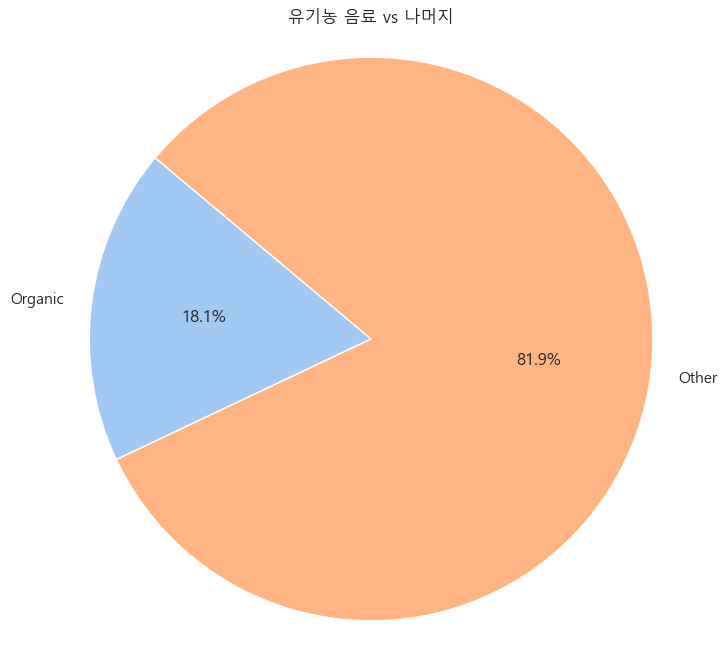

In [52]:
data = [organic_fj.values.sum(), f_j_d_c.values.sum() - organic_fj.values.sum()]
labels = ['Organic', 'Other']

plt.figure(figsize=(8, 8))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)

plt.title('유기농 음료 vs 나머지')
plt.axis('equal')

plt.show()

* 카테고리별 판매율이 가장 저조한 냉동음료에서 조차도 총 판매품목 47개중 4개만이 유기농 제품
* 하지만 판매갯수 비율로만 따지면 20%에 육박함
* 이렇게 Organic이라는 키워드에 사람들이 끌린다는 증거가 됨

### 재방문 간격 분석
---
5. 마트에 가장 자주 방문해주신 단골 회원을 찾아라!
- 방문 주기가 짧고 방문횟수가 많은 회원
- 재방문까지 걸린 일자는 0일에서 30일까지로 분포한다. 0일은 당일에 재방문한 경우이다. 
- 재방문까지 걸린 일자에 결측치가 많은데, 이 경우는 첫 방문을 의미한다.
- 구매품목이 가장 많은 고객을 기준으로도 점수를 매긴다.

In [120]:
# 재방문 평균 계산
revisit_mean = df.groupby('user_id')['days_since_prior_order'].mean().reset_index()
revisit_mean.rename(columns={'days_since_prior_order': 'revisit_mean'}, inplace=True)
revisit_mean.head()

,user_id,revisit_mean
0,1,19.200000
1,2,18.009390
2,3,11.487179
3,4,15.357143
4,5,12.314286


In [121]:
# 재방문 횟수 계산
revisit_cnt = df.groupby(['user_id', 'order_id'])['days_since_prior_order'].nunique().reset_index()
revisit_cnt = revisit_cnt.groupby('user_id')['days_since_prior_order'].sum().reset_index()
revisit_cnt.rename(columns={'days_since_prior_order': 'revisit_count'}, inplace=True)
revisit_cnt.head()

,user_id,revisit_count
0,1,10
1,2,14
2,3,11
3,4,4
4,5,4


In [56]:
# 데이터 병합
revisit_merge = pd.merge(revisit_mean, revisit_cnt, on='user_id')
revisit_merge['revisit_mean'] = revisit_merge['revisit_mean'].astype(int)
revisit_merge.head()

,user_id,revisit_mean,revisit_count
0,1,19,10
1,2,18,14
2,3,11,11
3,4,15,4
4,5,12,4


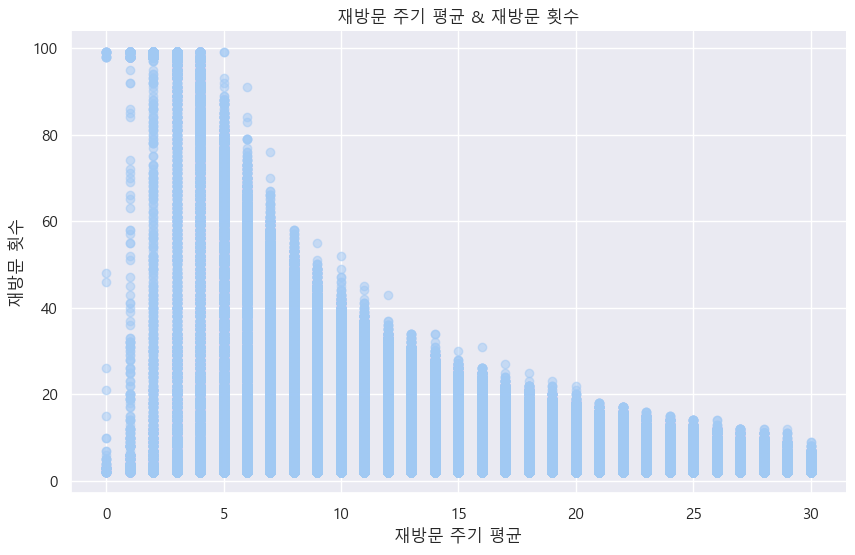

In [57]:
# 산포도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(revisit_merge['revisit_mean'], revisit_merge['revisit_count'], alpha=0.5)

plt.xlabel('재방문 주기 평균')
plt.ylabel('재방문 횟수')
plt.title('재방문 주기 평균 & 재방문 횟수')
plt.grid(True)

plt.show()

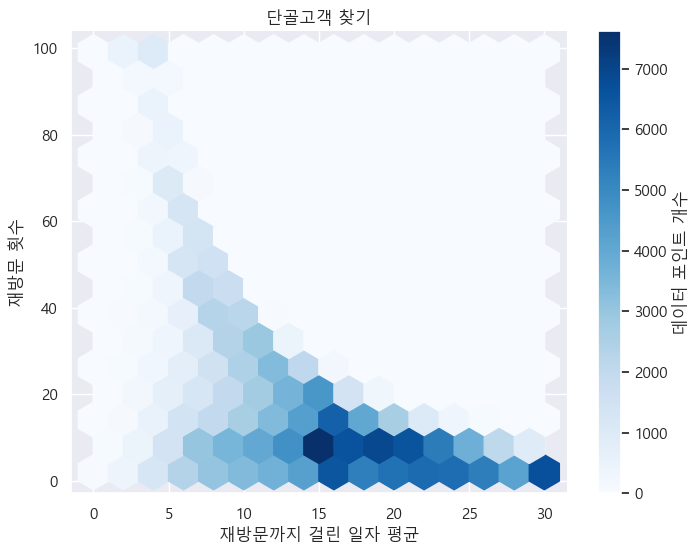

In [58]:
# Hexbin Plot 그리기
plt.figure(figsize=(8, 6))

x = revisit_merge['revisit_mean']
y = revisit_merge['revisit_count']
hb = plt.hexbin(x, y, gridsize=15, cmap='Blues')
plt.xlabel('재방문까지 걸린 일자 평균')
plt.ylabel('재방문 횟수')
plt.title('단골고객 찾기')

# 컬러 바 추가
cb = plt.colorbar(hb, label='데이터 포인트 개수')

plt.show()

* 시각화로 확인했지만 유의미한 결과를 도출할 수 없음.
* vip선정 기준에 구매물품 횟수 까지 포함해서 샘플링을 다시 시도해야함

In [106]:
# 구매물품기준 상위 고객 출력
top_user = df['user_id'].value_counts()
top_user = top_user[top_user > 1000]
top_user = top_user.reset_index()
top_user.columns = ['user_id', 'purchase_count']
top_user

,user_id,purchase_count
0,201268,3725
1,129928,3689
2,164055,3089
3,176478,2952
4,186704,2936
...,...,...
2181,177189,1001
2182,65807,1001
2183,999,1001
2184,187972,1001


In [107]:
# 위의 표를 토대로 재방문 기준 출력
top_revisit = pd.merge(top_user, revisit_merge, on='user_id', how='inner')
top_revisit

,user_id,purchase_count,revisit_mean,revisit_count,total_score
0,201268,3725,3,98,199
1,129928,3689,5,64,133
2,164055,3089,3,99,201
3,176478,2952,2,99,200
4,186704,2936,3,98,199
...,...,...,...,...,...
2181,177189,1001,5,49,103
2182,65807,1001,3,96,195
2183,999,1001,9,37,83
2184,187972,1001,2,99,200


* 해당 표를 토대로 다시 시각화 작업 필요

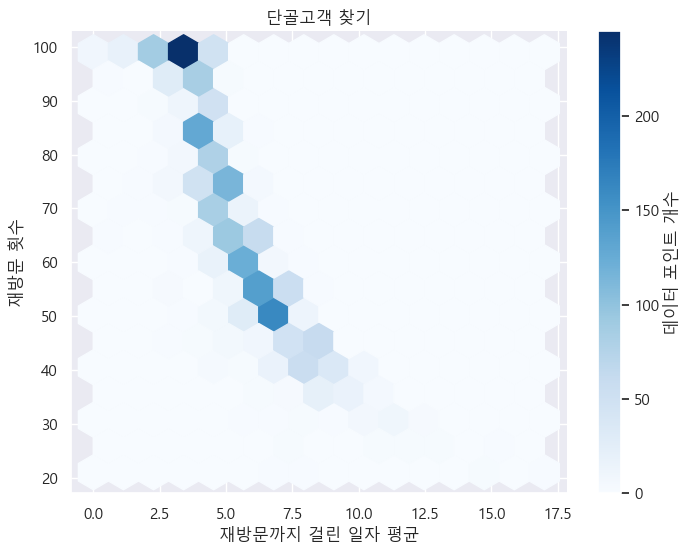

In [108]:
# Hexbin Plot 그리기
plt.figure(figsize=(8, 6))

x = top_revisit['revisit_mean']
y = top_revisit['revisit_count']
hb = plt.hexbin(x, y, gridsize=15, cmap='Blues')
plt.xlabel('재방문까지 걸린 일자 평균')
plt.ylabel('재방문 횟수')
plt.title('단골고객 찾기')

cb = plt.colorbar(hb, label='데이터 포인트 개수')

plt.show()

* 이상치에 해당하는 부분만 모아서 다시 시각화를 하니 평균일자가 비교적 적으면서 재방문 횟수가 높은 고객에 대한 시각화가 완성됨
* 재방문까지 걸린 일자 평균, 재방문 횟수, 구매물품 횟수 모두 고려하여 total_score를 생성하여 단골 고객을 찾는다.

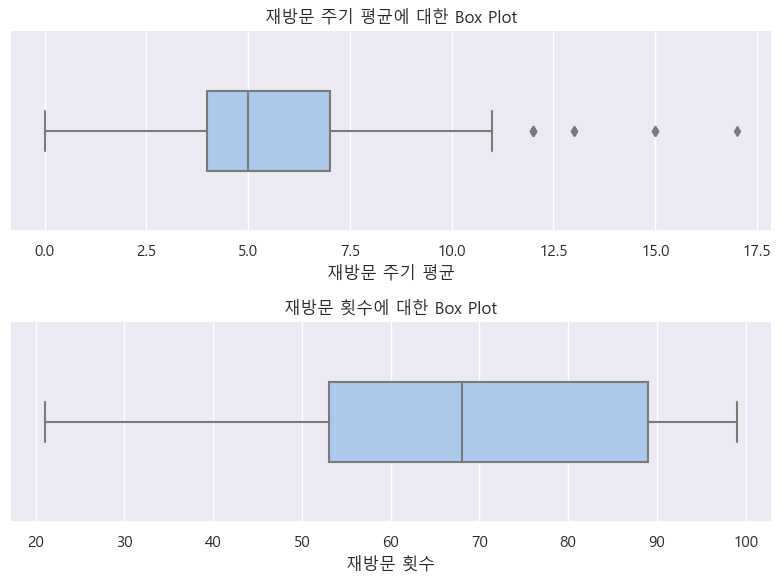

In [109]:
plt.figure(figsize=(8, 6))

# 첫 번째 Box Plot
plt.subplot(2, 1, 1)
sns.boxplot(x='revisit_mean', data=top_revisit, width=0.4)
plt.xlabel('재방문 주기 평균')
plt.title('재방문 주기 평균에 대한 Box Plot')

# 두 번째 Box Plot
plt.subplot(2, 1, 2)
sns.boxplot(x='revisit_count', data=top_revisit, width=0.4)
plt.xlabel('재방문 횟수')
plt.title('재방문 횟수에 대한 Box Plot')

# 그래프 표시
plt.tight_layout()
plt.show()

* 재방문 주기 평균이 낮으면서 재방문 횟수가 높다는 것은 vip선정기준에 적합함

In [110]:
# 재방문 주기 평균 10일 이하인 고객만 출력
revisit_10_under = top_revisit[top_revisit['revisit_mean'] < 10]
revisit_10_under

,user_id,purchase_count,revisit_mean,revisit_count,total_score
0,201268,3725,3,98,199
1,129928,3689,5,64,133
2,164055,3089,3,99,201
3,176478,2952,2,99,200
4,186704,2936,3,98,199
...,...,...,...,...,...
2181,177189,1001,5,49,103
2182,65807,1001,3,96,195
2183,999,1001,9,37,83
2184,187972,1001,2,99,200


In [111]:
w1 = 1.5    # 재방문까지 걸린 일자 평균의 가중치
w2 = 1      # 재방문 횟수의 가중치
w3 = 1.3    # 상품 구매 횟수의 가중치

revisit_10_under['total_score'] = (revisit_10_under['revisit_mean'] * w1) + \
                                  (revisit_10_under['revisit_count'] * w2) + \
                                  (revisit_10_under['purchase_count'] * w3)

# 현재 total_score 값 중 최소값과 최대값 계산
min_total_score = revisit_10_under['total_score'].min()
max_total_score = revisit_10_under['total_score'].max()

# 설정 범위 (0~100)로 최소값과 최대값 설정
min_target = 0
max_target = 100

# total_score 값을 0에서 100 사이로 스케일링
revisit_10_under['scaled_total_score'] = ((revisit_10_under['total_score'] - min_total_score) /
                                           (max_total_score - min_total_score)) * (max_target - min_target) + min_target
revisit_10_under['scaled_total_score'] = revisit_10_under['scaled_total_score'].round(1)

revisit_10_under

,user_id,purchase_count,revisit_mean,revisit_count,total_score,scaled_total_score
0,201268,3725,3,98,4945.0,100.0
1,129928,3689,5,64,4867.2,97.8
2,164055,3089,3,99,4119.2,77.0
3,176478,2952,2,99,3939.6,72.0
4,186704,2936,3,98,3919.3,71.5
...,...,...,...,...,...,...
2181,177189,1001,5,49,1357.8,0.2
2182,65807,1001,3,96,1401.8,1.4
2183,999,1001,9,37,1351.8,0.0
2184,187972,1001,2,99,1403.3,1.4


In [112]:
# 재방문까지 걸린 일자 평균이 가장 큰 값은?
revisit_10_under['revisit_mean'].max()

9

In [113]:
# 재방문 횟수에서 가장 작은 값은?
revisit_10_under['revisit_count'].min()

21

In [114]:
# 재방문 횟수에 대한 boxplot 결과를 참고하여 횟수가 80 이상인 고객으로 필터링
top_customers = revisit_10_under[revisit_10_under['revisit_count'] >= 80]
top_customers

,user_id,purchase_count,revisit_mean,revisit_count,total_score,scaled_total_score
0,201268,3725,3,98,4945.0,100.0
2,164055,3089,3,99,4119.2,77.0
3,176478,2952,2,99,3939.6,72.0
4,186704,2936,3,98,3919.3,71.5
5,137629,2931,3,99,3913.8,71.3
...,...,...,...,...,...,...
2171,173344,1002,4,82,1390.6,1.1
2175,12772,1001,3,99,1404.8,1.5
2176,186835,1001,3,98,1403.8,1.4
2182,65807,1001,3,96,1401.8,1.4


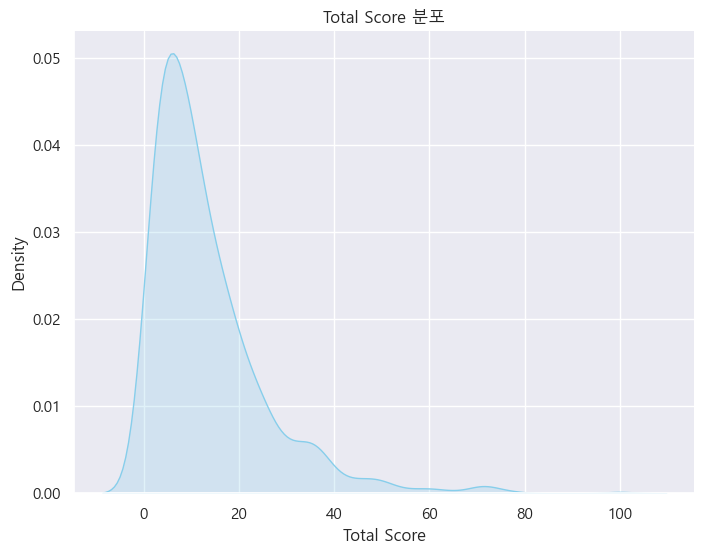

In [115]:
# KDE 그래프 그리기
plt.figure(figsize=(8, 6))
sns.kdeplot(data=top_customers['scaled_total_score'], shade=True, color='skyblue')
plt.xlabel('Total Score')
plt.ylabel('Density')
plt.title('Total Score 분포')

plt.show()

* total_score의 스케일링으로 인해 최대점수인 100점을 기준으로 상대평가의 결과가 나옴
* 30점을 기준으로 빈도수가 많이 줄어듬
* vip선정기준으로 total_score점수 30점이상인 사람들만 뽑아보기

In [119]:
# vip 선정하기
vip = top_customers[top_customers['scaled_total_score'] >= 30].reset_index(drop = True)
print(len(vip))
vip

72


,user_id,purchase_count,revisit_mean,revisit_count,total_score,scaled_total_score
0,201268,3725,3,98,4945.0,100.0
1,164055,3089,3,99,4119.2,77.0
2,176478,2952,2,99,3939.6,72.0
3,186704,2936,3,98,3919.3,71.5
4,137629,2931,3,99,3913.8,71.3
...,...,...,...,...,...,...
67,93519,1807,1,98,2448.6,30.5
68,55935,1807,3,98,2451.6,30.6
69,73080,1806,2,98,2448.8,30.5
70,195573,1805,3,94,2445.0,30.4


* 총 72명의 vip 선정완료

### 워드 클라우드 시각화
* 총 3천3백만여개의 판매 품목의 제품명을 단어로 분리 후 고객이 가장 즐겨찾는 키워드를 시각화로 확인해보기

In [88]:
words = df['product_name'].values
x = list(words)

In [81]:
y = []
for i in x:
    y.extend(i.split(" "))

In [82]:
z = {}
for i in y:
    if i in z:
        z[i] += 1
    else:
        z[i] = 1

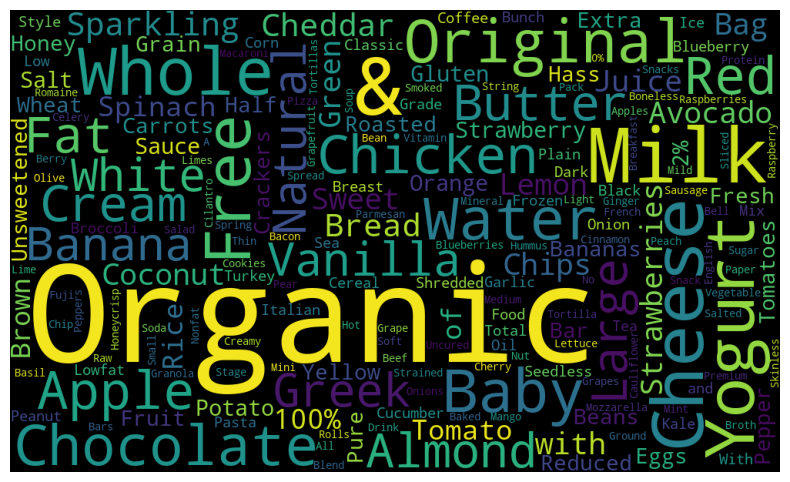

In [105]:
plt.figure(figsize=(10, 6))

wc = WordCloud(width=1000, height=600, background_color="black",random_state = 37)
plt.imshow(wc.generate_from_frequencies(z))
plt.axis("off")

plt.show()

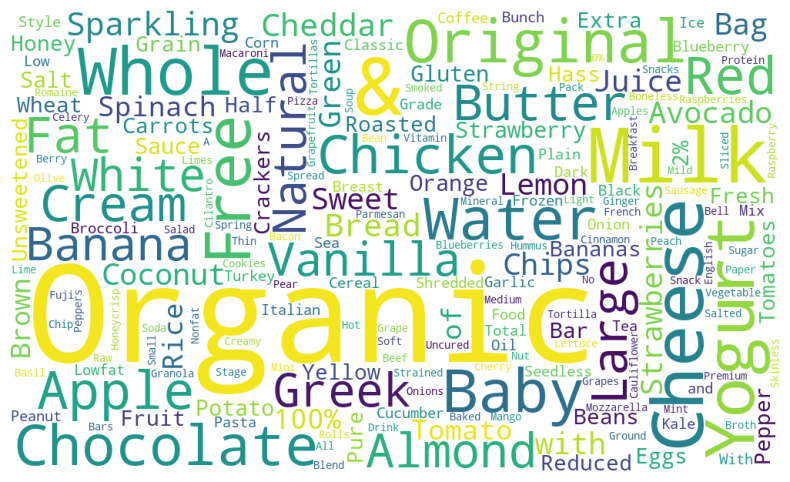

In [123]:
plt.figure(figsize=(10, 6))

wc = WordCloud(width=1000, height=600, background_color="white",random_state = 37)
plt.imshow(wc.generate_from_frequencies(z))
plt.axis("off")

plt.show()

### 데이터 시각화 분석 결과 요약
> 1. 가장 많이 팔린 품목  
> 바나나 단품과 바나나 한묶음이 가장 많이 팔린 제품으로 확인됨.  
> 흥미로운 점은 상위 10개 품목 대부분이 Organic(유기농) 제품임.  


> 2. 바나나 구매왕 찾기 이벤트  
> 가장 많은 바나나를 구매한 고객과, 가장 많이 재구매한 고객을 찾음.  
> 바나나 구매 횟수와 재구매 횟수가 상당히 유사함.  


> 3. 유기농 제품 분석  
> 유기농제품이 고객에게 끼치는 영향이 매우 크다는것을 발견.
> 데이터에서 유기농 제품은 10%의 비중을 차지함.   
> 유기농 제품은 전체 판매 품목 중 30% 이상을 차지함.  
> 유기농 제품 중 가장 많이 구매한 고객을 찾아 유기농 제품 선호도 파악.  


> 4. 재구매 집착증  
> 재구매 비율이 높은 상품 중 유의미한 판매 비율을 가진 제품 파악.  
> 재주문 비율이 높으면서 판매량이 동시에 높은 제품은 유제품으로써, 유제품의 경우는 고객의 니즈가 크게 작용하는 제품군임.
> 식품 카테고리 중에서도 유기농 제품 선호.  


> 5. 마트의 가장 Hot 코너 & Cool 코너  
> 상위 판매 품목은 모두 식품 카테고리.  
> 하위 판매 품목은 주류 및 식품과 관련이 없는 제품이 대다수.  
>  Hot & Cool선정 과정에서 가장 적게 팔린 분류에서 조차 유기농제품이 끼치는 영향의 바탕을 증거로 해당 키워드에 대한 확신 제공.    
> 판매하는 품목의 종류는 매우 다양하지만 현재 쇼핑몰에서 고객들이 가장 선호하는 제품군은 농작물을 비롯한 식품류임.


> 6. 단골 고객 찾기  
> 재방문 주기 평균이 짧으면서 재방문 횟수가 높은 고객을 찾아 단골 고객으로 선정.  
> 구매 물품 횟수도 고려하여 total_score를 생성하여 단골 고객 찾음.  
> total_score 스케일링하여 단골 고객 선정.  
> 방문 횟수를 토대로 단골고객선정을 하려 하였으나 데이터에서 제공하는 부분 중, 포괄 처리되어있는 부분이 있음을 발견 해서 새로운 기준을 한번 더 세움.   
> 재방문 데이터에서 30일 이상 넘어가는 경우는 모두 30일로 포괄처리됨    
> 재방문 데이터에서 재방문 횟수가 99회가 넘어가는 경우는 모두 99회로 포괄처리됨    


> 7. 판매 키워드 분석  
> 3천3백만여개의 판매 품목 중 가장 즐겨찾는 키워드를 시각화로 확인.  
> Organic 키워드가 상당한 영향력을 미침.  

### 전략 수립 및 실행  
> **1. 마트 인기 품목의 구매왕 찾기!**  
> - 소셜 미디어 챌린지: 이 챌린지를 주최하여 고객들에게 인기 제품을 소셜 미디어에서 홍보하고, 그 중에서 가장 많이 구매한 고객을 선정함. 이어서 선정된 고객에게 특별한 인센티브나 할인 혜택을 제공하여 다른 고객들도 동참하도록 유도함.


> **2. 유기농 제품을 파헤쳐 보자!**  
> - 유기농 제품 패키지: 유기농 제품을 한데 모은 특별한 유기농 패키지를 만들어서 구매할 때 추가 혜택을 제공함. 이를 통해 고객은 다양한 유기농 제품을 경험하고, 마트에서 유기농 제품을 주목하게 할 수 있음.  
> - 유기농 농장 투어: 마트와 협력하는 유기농 농장에서 유기농 제품 생산 과정을 보여주는 투어를 개최함. 이로써 고객들은 유기농 제품의 가치와 환경 친화적인 면을 직접 체험하게 됨.  


> **3. 사고 또 사고! 재구매왕!**  
> - 자동 재주문 서비스: 재구매율이 높은 상품에 대해 자동 재주문 서비스를 도입함. 고객은 자주 사는 상품을 자동으로 주문하고 특별 할인 혜택을 받을 수 있음.  
> - 커뮤니티 기반 리뷰 및 팁 공유: 재구매율이 높은 상품에 대한 온라인 커뮤니티를 운영함. 고객들은 제품 리뷰 및 사용 팁을 공유하고, 상품에 대한 경험을 나누는 공간을 제공함. 이로써 브랜드 로열티를 높이고, 상품에 대한 고객 만족도를 향상할 수 있음.


> **4. 마트의 가장 Hot 코너 & Cool 코너**  
> - 시각적 경험 강화: 사이트 내에서 Hot 코너와 Cool 코너를 더욱 시각적으로 강조하고, 해당 상품에 대한 상세 정보와 판촉 이벤트를 시각적으로 제공함.  
> - 코너 경품 추첨: Hot 코너와 Cool 코너에서 구매한 고객들을 대상으로 경품 추첨 이벤트를 주최하여 더 다양한 상품을 판매할 수 있도록 유도합니다.   


> **5. 마트에 자주 방문하는 단골 고객 찾기**  
> - 맞춤형 상품 추천: 단골 고객의 이전 구매 기록을 기반으로 맞춤형 상품 추천을 제공합니다. 이를 통해 고객은 더욱 편리하게 쇼핑을 할 수 있음.  
> - VIP 전용 이벤트 및 선점 판매: VIP 멤버들을 위한 독점 이벤트를 주최하고, 특정 상품의 선점 판매 기회를 제공하여 특별한 구매 경험을 제공함.  

> **6. 판매 키워드 분석**  
> - 키워드 주도 마케팅: 가장 인기 있는 키워드에 맞춘 제품 라인업을 개발하고, 해당 키워드와 관련된 캠페인을 진행하여 인기 제품과 관련된 트렌드에 민감하게 대응함.  
> - 소셜 미디어 활용: 특정 키워드를 활용한 해시태그 및 캠페인을 소셜 미디어에 활발하게 공유하여 고객 참여를 유도하고 제품 홍보를 강화함. 